## Final Project 3 Submission

Please fill out:
* Student name: Zhiqiang Sun
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Business problem

Build a classifier to predict whether a customer will ("soon") stop doing business with SyriaTel, a telecommunications company. Note that this is a binary classification problem.

Most naturally, your audience here would be the telecom business itself, interested in losing money on customers who don't stick around very long. Are there any predictable patterns here?




# Plan
Since the SyriaTel Customer Churn is a binary classification problem problem, I will try to use several different algorithms to fit the data and select one of the best one. The algorithms I will try include Logistic Regression, k-Nearest Neighbors, Decision Trees, Random Forest, Support Vector Machine. 
The target of the data we need to fit is the column 'churn'.
The features of the data is the other columns in dataframe. 
However, when I load the data file into dataframe, i found some of the columns are linear correlated with each other. I need to drop one of them. We need to polish the data first. 

In [2]:
#import all the necessary library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  accuracy_score, f1_score, recall_score, precision_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('bigml.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
# Check the infomation about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

#### Looking at the dataframe, I need to steply polish some features and remove some of the columns: 
1. The pairs of features inclued (total night minutes and total night charges), (total day minutes and total night charges), (total night minutes and total night charges), (total intl charge and total intl minutes) are high correlated with each other. I need to remove one in each columns. 
2. All the phone numbers are unique and act as id. So it should not related to the target. I will remove this feature.
3. The object columns will be catalized. 


In [5]:
# Drop the unique columns and one of each high correlated columns
to_drop = ['state', 'phone number', 'total day minutes', 'total night minutes', 'total night minutes' , 'total intl minutes']
df_polished = df.drop(to_drop, axis = 1)
df_polished.head()

,account length,area code,international plan,voice mail plan,number vmail messages,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls,churn
0,128,415,no,yes,25,110,45.07,197.4,99,16.78,91,11.01,3,2.70,1,False
1,107,415,no,yes,26,123,27.47,195.5,103,16.62,103,11.45,3,3.70,1,False
2,137,415,no,no,0,114,41.38,121.2,110,10.30,104,7.32,5,3.29,0,False
3,84,408,yes,no,0,71,50.90,61.9,88,5.26,89,8.86,7,1.78,2,False
4,75,415,yes,no,0,113,28.34,148.3,122,12.61,121,8.41,3,2.73,3,False


In [6]:
# The object features need to be catlized
to_cat_1 = [ 'international plan', 'voice mail plan' ]
df_cat = pd.DataFrame()
for col in to_cat_1:
    df_cat = pd.concat([df_cat, pd.get_dummies(df_polished[col], prefix=col, drop_first=True)], axis = 1)
df_cat.head()

,international plan_yes,voice mail plan_yes
0,0,1
1,0,1
2,0,0
3,1,0
4,1,0


In [7]:
to_cat_2 = [  'area code' ]
df_cat2 = pd.DataFrame()
for col in to_cat_2:
    df_cat2 = pd.concat([df_cat2, pd.get_dummies(df_polished[col], prefix=col, drop_first=False)], axis = 1)
df_cat2.head()

,area code_408,area code_415,area code_510
0,0,1,0
1,0,1,0
2,0,1,0
3,1,0,0
4,0,1,0


In [8]:
df_polished_2 = pd.concat([df_polished, df_cat, df_cat2], axis = 1)

In [9]:
to_drop_2 = ['international plan', 'voice mail plan' , 'area code'  ]
df_polished_3 = df_polished_2.drop(to_drop_2, axis=1)
df_polished_3.columns


Index(['account length', 'number vmail messages', 'total day calls',
       'total day charge', 'total eve minutes', 'total eve calls',
       'total eve charge', 'total night calls', 'total night charge',
       'total intl calls', 'total intl charge', 'customer service calls',
       'churn', 'international plan_yes', 'voice mail plan_yes',
       'area code_408', 'area code_415', 'area code_510'],
      dtype='object')

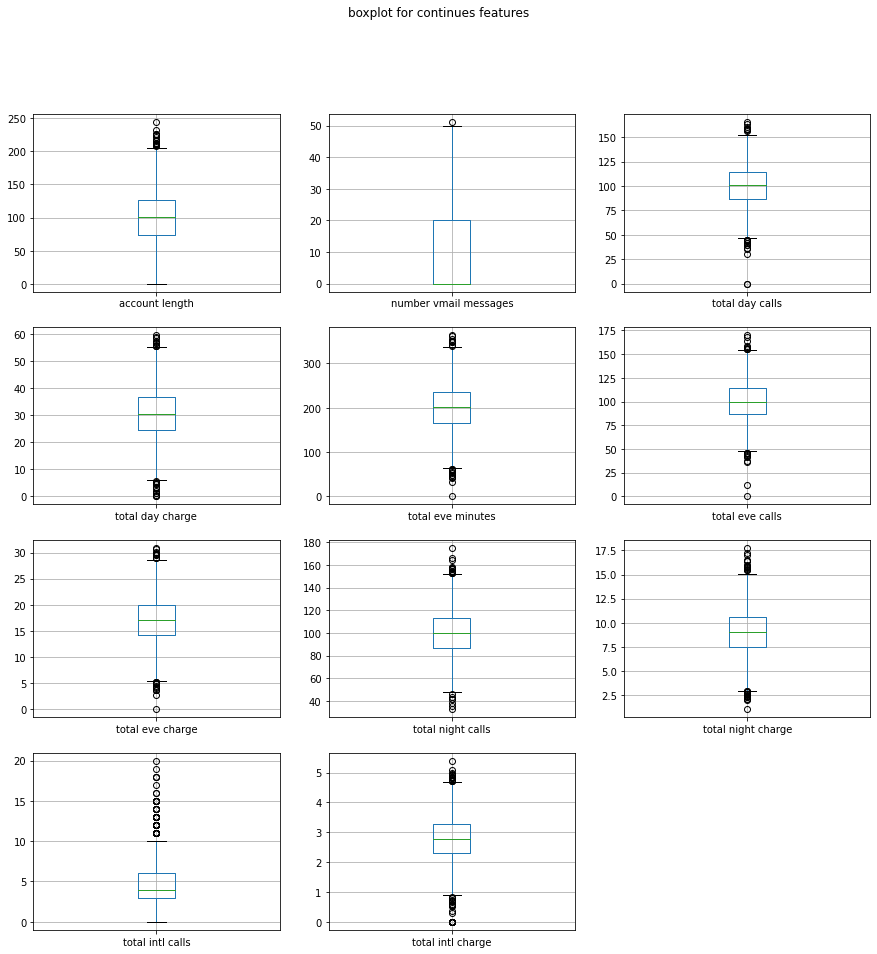

In [10]:
to_plot= ['account length',  'number vmail messages', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night calls', 'total night charge', 'total intl calls',
       'total intl charge']
fig, axes = plt.subplots(figsize = (15,15))
fig.suptitle('boxplot for continues features')
for idx, col in enumerate(to_plot):
    
    plt.subplot(4,3,idx+1)
    
    df_polished_3.boxplot(col)

In [11]:
#It looks like most of the frames contain outlier values which may impact our fitting and predicting to the final results. We will try to remove the ouliers.

df_polished_4 = df_polished_3.copy()
for col in to_plot:
    Q1 = df_polished_3[col].quantile(0.25)
    Q3 = df_polished_3[col].quantile(0.75)
    IQR = Q3 - Q1
    df_polished_4 = df_polished_4[(df_polished_3[col] >= Q1 - 1.5*IQR) & (df_polished_3[col] <= Q3 + 1.5*IQR)]


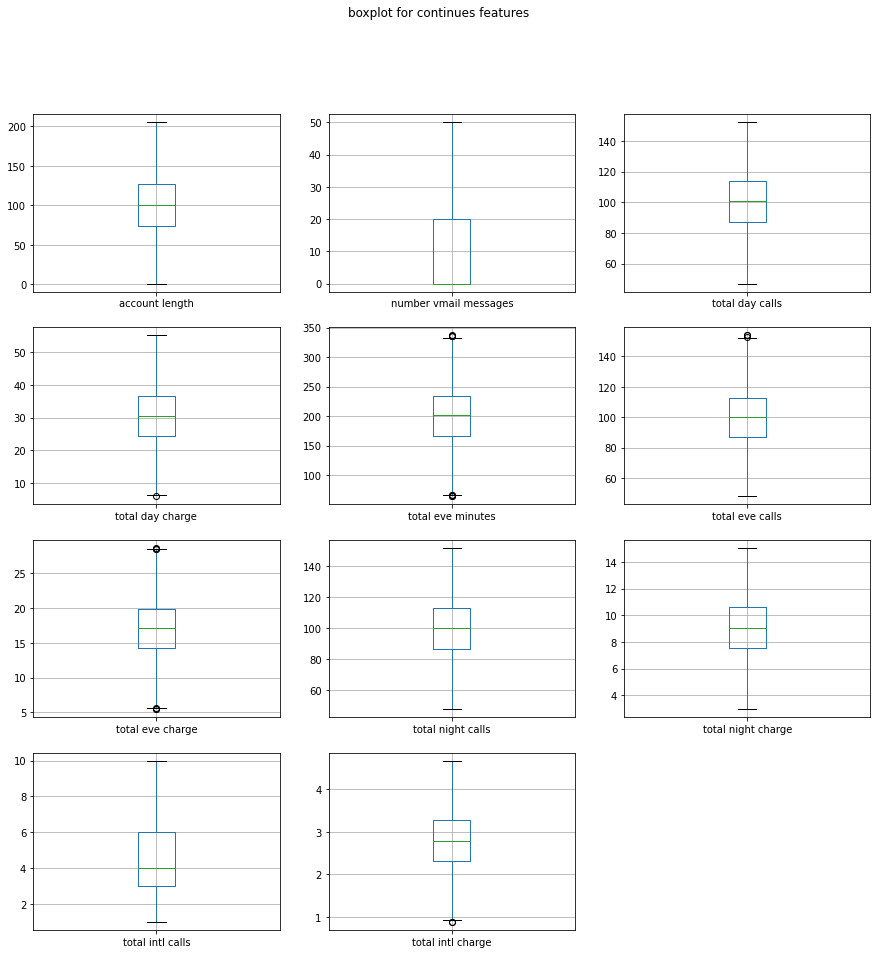

In [12]:

fig, axes = plt.subplots(figsize = (15,15))
fig.suptitle('boxplot for continues features')
for idx, col in enumerate(to_plot):
    
    plt.subplot(4,3,idx+1)
    
    df_polished_4.boxplot(col)

# Now the data was ready and we need to prepare and modeling the data with varies models.

### Plan

#### 1. Perform a Train-Test Split

For a complete end-to-end ML process, we need to create a holdout set that we will use at the very end to evaluate our final model's performance.

#### 2. Build and Evaluate several Model including Logistic Regression, k-Nearest Neighbors, Decision Trees, Randdom forest, Support Vector Machine.
##### For each of the model, we need several steps
    1. Build and Evaluate a base model
    2. Build and Evaluate Additional Logistic Regression Models
    3. Choose and Evaluate a Final Model
#### 3. Compare all the models and find the best model



### 1.  Prepare the Data for Modeling
The target is Cover_Type. In the cell below, split df into X and y, then perform a train-test split with random_state=42 and stratify=y to create variables with the standard X_train, X_test, y_train, y_test names.

In [13]:
y = df_polished_4['churn'] * 1   #extract target and convert from boolen to int type
X = df_polished_4.drop('churn', axis= 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Since the X features are in different scales, we need to make them to same scale.
Now instantiate a StandardScaler, fit it on X_train, and create new variables X_train_scaled and X_test_scaled containing values transformed with the scaler.

In [14]:

scale = StandardScaler()
scale.fit(X_train)
X_train_scaled = scale.transform(X_train)
X_test_scaled = scale.transform(X_test)

As the data is inbalanced, I used smote to make the training data balanced before fitting.

In [15]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train_scaled, y_train) 

### 2. Build and Evaluate several Model

######  I. Build the model with Logistic Regression

In [16]:
# Instantiate a LogisticRegression with random_state=42
Log = LogisticRegression(random_state=42)
a = Log.fit(X_train, y_train)


accuracy_score is  0.76832
f1_score is  0.5124
recall_score 0.82301
precision_score 0.372


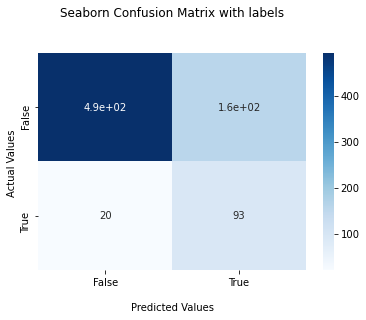

In [17]:
# Make a method to plot the confusion box and the accuracy, recall, precision and F1 score.
def plot_confusion(model, X_test_scaled, y_test):   
    y_hat_test = model.predict(X_test_scaled)
    
    print('accuracy_score is ', round(accuracy_score( y_test, y_hat_test), 5))
    print('f1_score is ', round(f1_score( y_test, y_hat_test), 5))
    print('recall_score', round(recall_score( y_test, y_hat_test), 5))
    print('precision_score', round(precision_score( y_test, y_hat_test), 5))


    cf_matrix  = confusion_matrix(y_test,y_hat_test)

    # make the plot of cufusion matrix 
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
plot_confusion(Log, X_test_scaled, y_test)  

The confusion box shows massive TN data compared to the TP, FP, and FN. In this project,  the main focus of our fitting is on TP, which is the customers who will churn the plan. In this case, the accuracy, including the TN data, is not work in our project. However, the f1 score, which combines both recall and precision data, looks well working for our fitting. 
The confusion box for  Logistic Regression fitting shows there is too much FP, and the F1 score is not high enough. Thus the Logistic Regression is not working well for these data. 

######  II. Build the model with  k-Nearest Neighbors

accuracy_score is  0.79058
f1_score is  0.49367
recall_score 0.69027
precision_score 0.38424


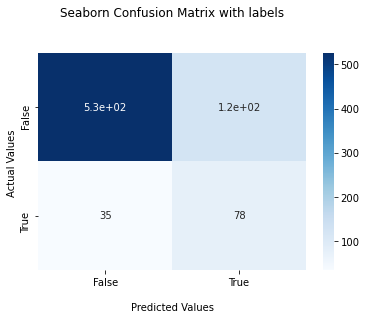

In [18]:
# For k-Nearest Neighbors, I first build the base line model
knn_base = KNeighborsClassifier()
knn_base.fit(X_train, y_train)
plot_confusion(knn_base, X_test_scaled, y_test)  

The scores for KNeighborsClassifier are pretty high. But the score for traing is higher than testing data. We will try to use other parameter to find the best number of neighbor used for fitting.

In [19]:
#set the list of n_neighbors we will try
knn_param_grid = {
    'n_neighbors' : [1,3,5,6,7,8,9, 10]
}
knn_param_grid =  GridSearchCV(knn_base, knn_param_grid, cv=3, return_train_score=True)

In [20]:
#fit the model to data
knn_param_grid.fit(X_train, y_train)
# find the best parameter
knn_param_grid.best_estimator_

KNeighborsClassifier(n_neighbors=1)

accuracy_score is  0.82068
f1_score is  0.45418
recall_score 0.50442
precision_score 0.41304


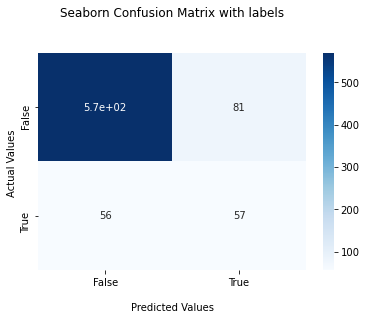

In [21]:
# fit the data with best estimator
knn_base_best = KNeighborsClassifier(n_neighbors=1)
knn_base_best.fit(X_train, y_train)

plot_confusion(knn_base_best, X_test_scaled, y_test)  

For data fit to model with k-Nearest Neighbors, the f1 score is still low because there is a lot of FP data. 

######  III. Build the model with Decision Trees

accuracy_score is  0.87696
f1_score is  0.624
recall_score 0.69027
precision_score 0.56934


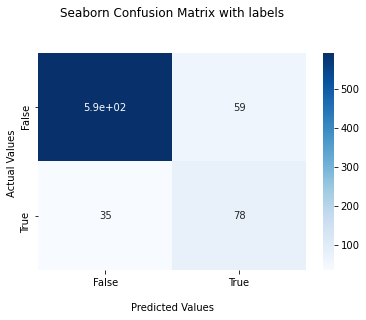

In [24]:
# set the baseline model for DecisionTreeClassifier
DT_baseline = DecisionTreeClassifier(random_state=42)
DT_baseline.fit(X_train, y_train)

plot_confusion(DT_baseline, X_test_scaled, y_test)  

The f1 score for DT is not high also.

In [25]:
#set the list of parameters we will try

dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5 , 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1, 2, 3, 4, 5, 6]
}
dt_grid_search =  GridSearchCV(DT_baseline, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)
# find best parameters
dt_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

accuracy_score is  0.9123
f1_score is  0.70996
recall_score 0.72566
precision_score 0.69492


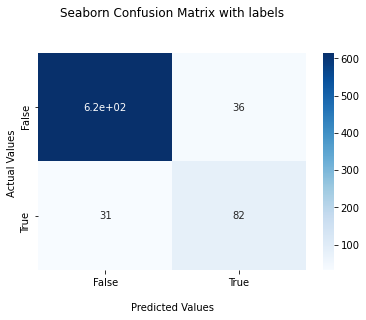

In [26]:
# refit the model to data with best parameters
DT_baseline_best = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=10,
                                          min_samples_leaf=1, min_samples_split=2)
DT_baseline_best.fit(X_train, y_train)
plot_confusion(DT_baseline_best, X_test_scaled, y_test)  

Compare to the first to model, Decision Tree gives us better f1 score. However, it is still not high enough since FP and FN are still high compare to TP. 

######  IV. Build the model with  Support Vector Machine

accuracy_score is  0.87696
f1_score is  0.63281
recall_score 0.71681
precision_score 0.56643


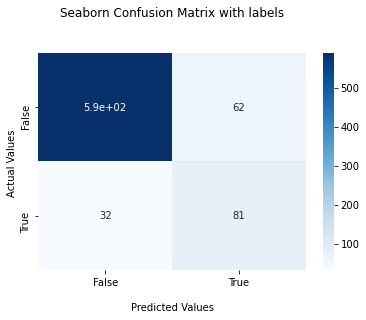

In [27]:
# set the baseline model for Support Vector Machine
svm_baseline = SVC()
svm_baseline.fit(X_train, y_train)


plot_confusion(svm_baseline, X_test_scaled, y_test)  

In [28]:
#set the list of parameters we will try

svm_param_grid = {
    'C' :[0.1, 1, 5, 10, 100],
    'kernel': ['poly', 'rbf'],
    'gamma': [0.1, 1, 10, 'auto'],
    

}
svm_grid_search =  GridSearchCV(svm_baseline, svm_param_grid, cv=3, return_train_score=True)

svm_grid_search.fit( X_train, y_train)

svm_grid_search.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

accuracy_score is  0.86911
f1_score is  0.53271
recall_score 0.50442
precision_score 0.56436


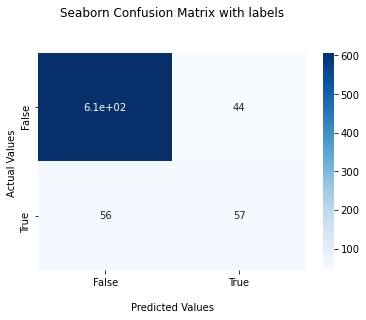

In [29]:
# refit the model to data with best parameters

svm_baseline_best = SVC(C= 10, gamma= 0.1, kernel= 'rbf')
svm_baseline_best.fit(X_train, y_train)

plot_confusion(svm_baseline_best, X_test_scaled, y_test)  

The results for SVM model does not looks good as the f1 score is very low.

######  V. Build the model with RandomForestClassifier

accuracy_score is  0.94241
f1_score is  0.80531
recall_score 0.80531
precision_score 0.80531


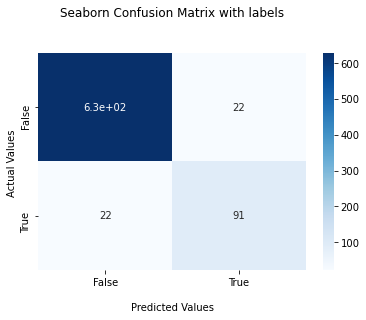

In [30]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

plot_confusion(rf_clf, X_test_scaled, y_test)  

In [31]:
rf_param_grid = {
    'n_estimators' : [10, 30, 100],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 2, 6, 10],
    'min_samples_split' : [5, 10],
    'min_samples_leaf' : [3, 6],
    
}
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv =3)

rf_grid_search.fit(X_train, y_train)
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")


Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


accuracy_score is  0.94895
f1_score is  0.83117
recall_score 0.84956
precision_score 0.81356


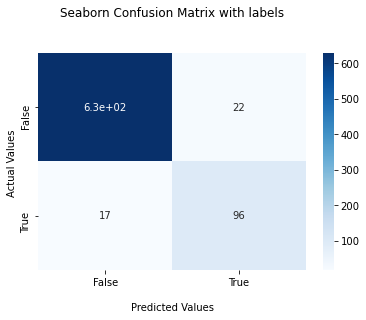

In [34]:
rf_clf_best = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=3, min_samples_split=5, n_estimators = 100)
rf_clf_best.fit(X_train, y_train)

plot_confusion(rf_clf_best, X_test_scaled, y_test)  

Compare to other four models, the model of Random Forest gives us best results on the f1 scores. The TP in confusion matrix incresed and the FP, FN decresed. Thus we selected random Forest for our final model.

 #### Compare all the models and find the best model, then evaluate it.

 The final score for training and testing data are very high and close to each other which suggest there is no overfit or downfit to the trainning data. Now let find out the weight of each features to the target results. 

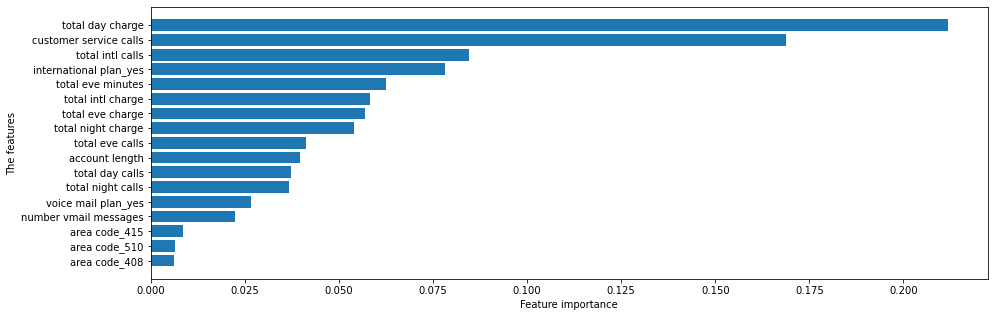

total day charge 0.21184308289677392
customer service calls 0.16868781183541365
total intl calls 0.08463497091973587
international plan_yes 0.0781320767218108
total eve minutes 0.06242784467555647


In [36]:
importance_DT = rf_clf_best.feature_importances_
col = []
val = []
combine = []
# summarize feature importance
for i,v in zip(X.columns, importance_DT):
    
    combine.append((i, v))
# plot feature importance
plt.figure(figsize = (15, 5))

sort_features =sorted(combine, key = lambda x:x[1])

col = [feat[0] for feat in sort_features]
val = [feat[1] for feat in sort_features]



plt.barh(col, val,  align='center')
plt.xlabel('Feature importance')
plt.ylabel('The features')


plt.show()
for i in range (16 , 11, -1):
    
    print(col[i], val[i])

The top 5 features are total day charge, customer service calls,  international plan_yes, total intl calls, total eve minutes.

### Check if there is special patten for the top five important features

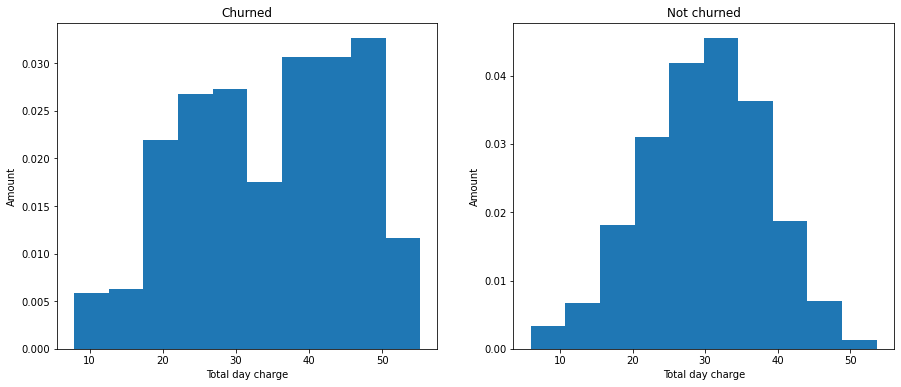

In [351]:
# Plot the histogram for total day charge of customers who churned and not churned.
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.hist(df_polished_4[df_polished_4['churn'] == 1]['total day charge'], density=True)
plt.xlabel('Total day charge')
plt.ylabel('Amount')
plt.title('Churned')


plt.subplot(1,2,2)
plt.hist(df_polished_4[df_polished_4['churn'] == 0]['total day charge'], density=True)
plt.xlabel('Total day charge')
plt.ylabel('Amount')
plt.title('Not churned')
plt.show()

The histograms for customers who churned and not churned show that the total day chare have a lot of overlap with each other.The customers who had total day charg more than 40 have more chance to churn the plan. 

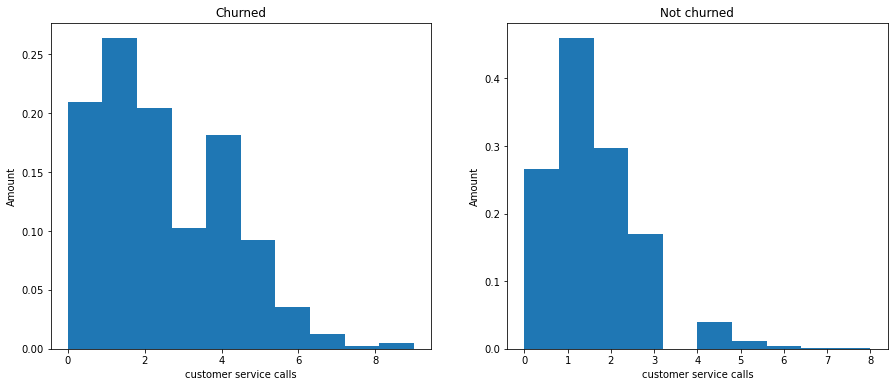

In [352]:
# Plot the histogram for 'customer service calls' of customers who churned and not churned.

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.hist(df_polished_4[df_polished_4['churn'] == 1]['customer service calls'],  density=True)
plt.xlabel('customer service calls')

plt.ylabel('Amount')
plt.title('Churned')
plt.subplot(1,2,2)
plt.hist(df_polished_4[df_polished_4['churn'] == 0]['customer service calls'],  density=True)
plt.xlabel('customer service calls')
plt.ylabel('Amount')
plt.title('Not churned')
plt.show()

The histogram are similar to each other. However, the customer who had 4 international calls had  higher chance to churn the plan. 

     not churn     churn
 No   0.721198  0.278802
Yes   0.933944  0.066056


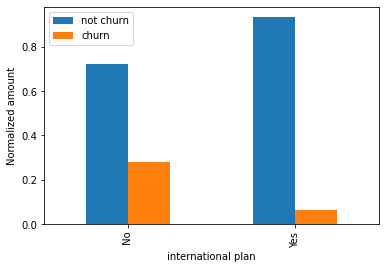

In [119]:
churn = df_polished_4[df_polished_4['churn'] == 1]['international plan_yes'].value_counts(normalize=True)
not_churn = df_polished_4[df_polished_4['churn'] == 0]['international plan_yes'].value_counts(normalize=True)
df_churn = pd.DataFrame([ churn, not_churn ], index =[' No', 'Yes'])
df_churn.columns = ['not churn', 'churn']
print(df_churn)
df_churn.plot(kind = 'bar', xlabel = 'international plan', ylabel = 'Normalized amount')
plt.show()

This data show that the customers who have international plan have 27% chance to churn the service. But the customers who do not have the  international plan have only 6.7% chance to churn the service. 

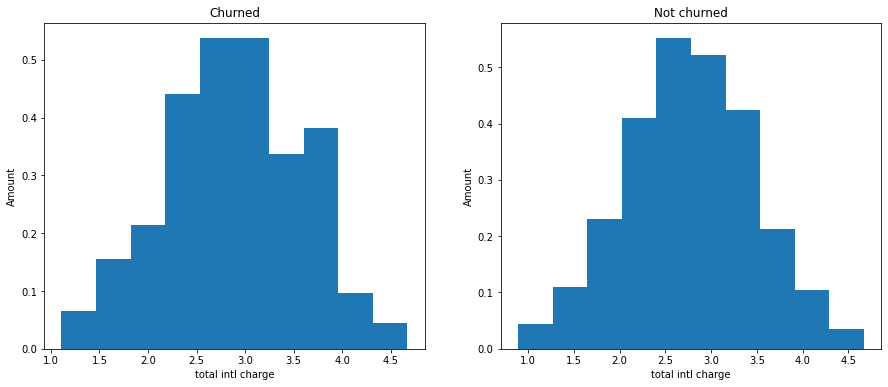

In [45]:
# Plot the histogram for 'total intl charge' of customers who churned and not churned.

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.hist(df_polished_4[df_polished_4['churn'] == 1]['total intl charge'], density=True)
plt.xlabel('total intl charge')
plt.ylabel('Amount')
plt.title('Churned')
plt.subplot(1,2,2)
plt.hist(df_polished_4[df_polished_4['churn'] == 0]['total intl charge'], density=True)
plt.xlabel('total intl charge')
plt.ylabel('Amount')
plt.title('Not churned')
plt.show()

There is no clear relationship between total intl charge and churn or not.

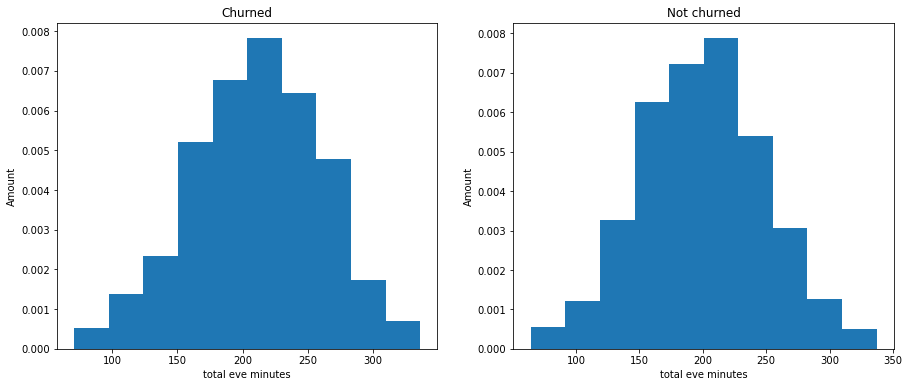

In [50]:
# Plot the histogram for 'total eve minutes' of customers who churned and not churned.

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.hist(df_polished_4[df_polished_4['churn'] == 1]['total eve minutes'], density=True)
plt.xlabel('total eve minutes')
plt.ylabel('Amount')
plt.title('Churned')

plt.subplot(1,2,2)
plt.hist(df_polished_4[df_polished_4['churn'] == 0]['total eve minutes'], density=True)
plt.xlabel('total eve minutes')
plt.ylabel('Amount')
plt.title('Not churned')
plt.show()


There is no clear relationship between total eve minutes and churn or not.

# Conclusion

We polished our original data by removing the outlier and catalyzing the necessary columns. We then tested several models to fit out data and selected the best one, Random Forest. The final score of predicting is 0.83117, which is very high. 
By plotting the feature importance, we found that the top 5 weighted features are total day charge, customer service calls, international plan_yes, total intl calls, and eve minutes. 
We then plot the histogram of each feature separated by the customers who churn and not churn the plan. 
We found that customers who had day charge more than 40 or had customer service call four and more or had an international plan had a higher chance of churning the service.
The results of total day charge and customer service calls suggest customers using Syriatel service more often have a higher chance of churning the service. Thus, Syriatel company can promote the service charge to attract people to use more of that. They also need to make the customer service friendlier and more professional to help customers address the problems.
The international plan is also crucial for customers to churn the service. Based on this point, Syriatel can also make some memorable plans if more customers use the international program. 